# Grad-CAM class activation visualization (EfficientNetB0)

Here I use EfficientNetB0 pretrained on ImageNet as base model. To this base model I add an input layer and some output layers that are used for classification.

I use a few test images and extract the kernel weights from last convolutional layer. The heatmap as well as the gradient-weighted class activation mapping (Grad-CAM) are plotted for each test image.

## 1. Import packages and define class names

In [23]:
import numpy as np
import os
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.preprocessing import image
from keras.applications.efficientnet import EfficientNetB0
from keras.applications.efficientnet import preprocess_input

In [3]:
class_names = ['adenosis',
            'ductal_carcinoma',
            'fibroadenoma',
            'lobular_carcinoma',
            'mucinous_carcinoma',
            'papillary_carcinoma',
            'phyllodes_tumor',
            'tubular_adenoma']

## 2. Define image generator

In [4]:
image_generator_train = ImageDataGenerator()

In [5]:
image_generator_valtest = ImageDataGenerator()

In [6]:
image40Xtrain = image_generator_train.flow_from_directory(
    os.path.join('data','split','40X','train'),
    batch_size=16, 
    target_size=(460,700),
    class_mode = 'sparse',
    shuffle=True
)

Found 1594 images belonging to 8 classes.


In [7]:
image40Xval = image_generator_valtest.flow_from_directory(
    os.path.join('data','split','40X','val'),
    batch_size=16, 
    target_size=(460,700),
    class_mode = 'sparse',
    shuffle=True
)

Found 195 images belonging to 8 classes.


In [8]:
image40Xtest = image_generator_valtest.flow_from_directory(
    os.path.join('data','split','40X','test'),
    batch_size=16, 
    target_size=(460,700),
    class_mode = 'sparse',
    shuffle=True
)

Found 206 images belonging to 8 classes.


https://keras.io/examples/vision/grad_cam/  
https://jacobgil.github.io/deeplearning/class-activation-maps

## 3. Define functions to compute and display heatmap

In [9]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    print('class_channel:', class_channel)
    print('pred_index:', pred_index)
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), pred_index, class_channel

In [10]:
def display_gradcam(img, heatmap, alpha=0.4):
    # Load the original image
    #img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    #superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(superimposed_img))
    #plt.imshow(superimposed_img)
    return([img/255, jet_heatmap/255, superimposed_img])

## 4. Define model from which we can access top convolutional layer

see https://stackoverflow.com/a/66189774 (Section «Model»)

In [11]:
input_tensor = keras.Input(shape=(460, 700, 3))

In [12]:
effnet_model = keras.applications.EfficientNetB0(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    include_top=False,  # Do not include the ImageNet classifier at the top.
    input_tensor = input_tensor
)  

2022-03-10 18:22:41.480110: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
pooling = keras.layers.GlobalAveragePooling2D()(effnet_model.output)
pooling

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>

In [14]:
dropout = keras.layers.Dropout(0.2)(pooling)  # Regularize with dropout
dropout

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'dropout')>

In [15]:
outputs = keras.layers.Dense(8)(dropout)
outputs

<KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'dense')>

In [17]:
# bind all
func_model = keras.Model(effnet_model.input, outputs)

In [18]:
# print first few and last few layers
a=[]
func_model.summary(print_fn = lambda x: a.append(x))
b=np.r_[a[:20],
        ['...layers skipped...'],
        ['__________________________________________________________________________________________________'],
        a[-20:]]
print(b)

['Model: "model"'
 '__________________________________________________________________________________________________'
 'Layer (type)                    Output Shape         Param #     Connected to                     '
 '=================================================================================================='
 'input_1 (InputLayer)            [(None, 460, 700, 3) 0                                            '
 '__________________________________________________________________________________________________'
 'rescaling (Rescaling)           (None, 460, 700, 3)  0           input_1[0][0]                    '
 '__________________________________________________________________________________________________'
 'normalization (Normalization)   (None, 460, 700, 3)  7           rescaling[0][0]                  '
 '__________________________________________________________________________________________________'
 'stem_conv_pad (ZeroPadding2D)   (None, 461, 701, 3)  0        

## 5. Get test images

In [19]:
image40Xtest.reset()

In [20]:
# Print shape of images and labels
imgs, labels = image40Xtest.next()
print('Images:', imgs.shape)
print('Labels:', labels.shape)

Images: (16, 460, 700, 3)
Labels: (16,)


In [21]:
# Get first 5 test images
#img_array = preprocess_input(get_img_array(img_path, size=img_size))
#img_array=np.expand_dims(img_array, axis=0)
img_array = imgs[0:5,:,:,]
lab = labels[0:5]
print(img_array.shape, lab.shape)

(5, 460, 700, 3) (5,)


## 6. Plot heatmaps for test images

class_channel: tf.Tensor([0.8815193], shape=(1,), dtype=float32)
pred_index: tf.Tensor(0, shape=(), dtype=int64)
class_channel: tf.Tensor([1.1825253], shape=(1,), dtype=float32)
pred_index: tf.Tensor(0, shape=(), dtype=int64)
class_channel: tf.Tensor([1.2552797], shape=(1,), dtype=float32)
pred_index: tf.Tensor(0, shape=(), dtype=int64)
class_channel: tf.Tensor([0.46809337], shape=(1,), dtype=float32)
pred_index: tf.Tensor(4, shape=(), dtype=int64)
class_channel: tf.Tensor([1.1713523], shape=(1,), dtype=float32)
pred_index: tf.Tensor(0, shape=(), dtype=int64)


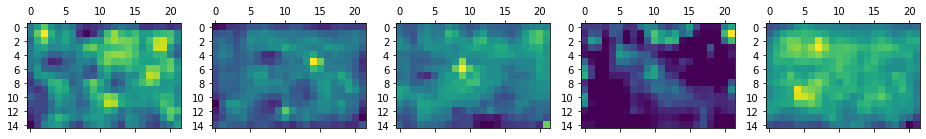

In [24]:
fig, axs = plt.subplots(1,5, figsize=(16,9))
heatmaps_dict = []
for i in range(5):
    # Generate class activation heatmap
    img_array_0=np.expand_dims(img_array[i,:,:,:], axis=0)
    heatmap, pred_index, class_channel = make_gradcam_heatmap(img_array_0, func_model, 'top_conv')
    heatmaps_dict.append({
        'heatmap': heatmap,
        'pred_index': pred_index,
        'class_channel': class_channel
    })

    # Display heatmap
    axs[i].matshow(heatmaps_dict[i]['heatmap'])
    #axs[i].show()

## 7. Plot Grad-CAM for test images

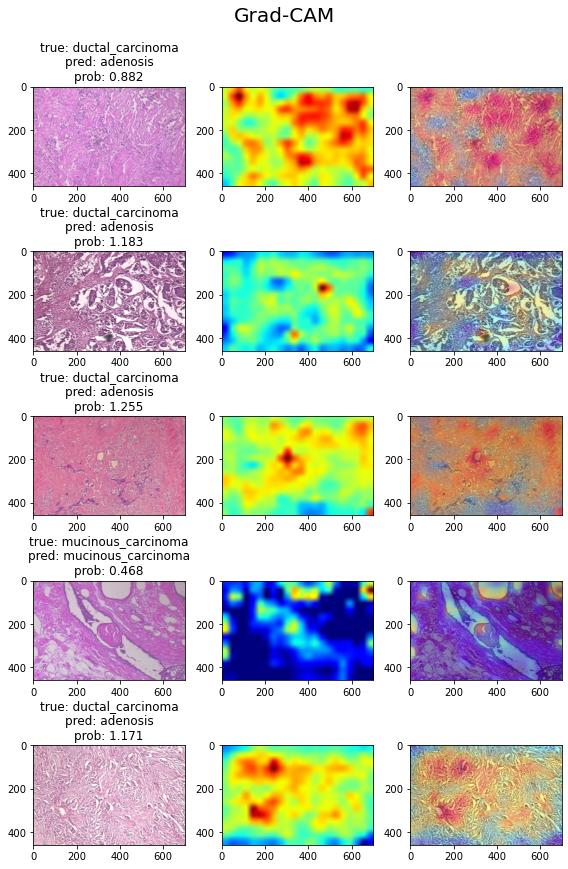

In [25]:
fig, axs = plt.subplots(5,3, figsize=(8,12))
for j in range(5):
    imgs_out = display_gradcam(imgs[j,:,:,:], heatmaps_dict[j]['heatmap'])
    for i in range(3):
        pred=heatmaps_dict[j]['pred_index'].numpy()
        class_prob=np.round(heatmaps_dict[j]['class_channel'][0], 3)
        class_pred=class_names[pred]
        tit1 = 'true: '+class_names[int(lab[j])]
        tit2 = '\npred: '+str(class_pred)+'\nprob: '+str(class_prob)
        tit=tit1+tit2
        axs[j,i].imshow(imgs_out[i])
        if i==0: axs[j,i].set_title(tit)
        
fig.suptitle('Grad-CAM', fontsize=20, verticalalignment='baseline')
fig.tight_layout()